# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [16]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from inspect import signature

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [17]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [18]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        # Default stride is (1, 1)
        # At first I used the default padding for the Conv2D layers
        # But I noticed that the teacher model will have less parameters than the student model
        # This is wrong so I applied the padding to it
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        # No default stride so we need to pass one
        tf.keras.layers.MaxPooling2D((2, 2), strides=1),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10),
    ],
    name='teacher',
)
cnn_model.build()
cnn_model.summary()



# Build fully connected student.
fc_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(10),
    ],
    name='student'
)
fc_model.build()
fc_model.summary()




Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0         
                                                                 
 dropout_2 (Dropout)         (None, 10816)             0   

# Teacher loss function

In [19]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
    and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)

  return cross_entropy_loss_value

# Student loss function

In [20]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, teacher=cnn_model, student=fc_model):
  """Compute subclass knowledge distillation student loss for given images
    and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.
  teacher_subclass_logits = teacher(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  cross_entropy_loss_value = cce(labels, student_subclass_logits)
  loss = ALPHA * distillation_loss_value + (1 - ALPHA) * cross_entropy_loss_value

  return loss

# Train and evaluation

In [21]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, teacher=cnn_model, student=fc_model):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  # The optimizer should be Adam, with a learning rate of 0.001 for all models
  optimizer = tf.keras.optimizers.Adam()

  train_loss_results = []
  train_accuracy_results = []

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    # print('Epoch {}: '.format(epoch), end='')
    epoch_loss_avg = tf.keras.metrics.Mean()
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        if len(signature(compute_loss_fn).parameters) == 4:
          loss_value = compute_loss_fn(images, labels, teacher=teacher, student=student)
        elif len(signature(compute_loss_fn).parameters) == 2:
          loss_value = compute_loss_fn(images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
      # Track progress
      epoch_loss_avg.update_state(loss_value)  # Add current batch loss
      train_loss_results.append(epoch_loss_avg.result())
      
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += compute_num_correct(model, images, labels)[0]
    # print("Class_accuracy: " + '{:.2f}%'.format(
    #     num_correct / num_total * 100))
    accuracy = (num_correct / num_total)
    train_accuracy_results.append(accuracy)
    print('Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.2%}'.format(epoch,
                                                                epoch_loss_avg.result(),
                                                                accuracy))

  return train_loss_results, train_accuracy_results

# Training models

In [22]:
train_and_evaluate(cnn_model, compute_teacher_loss)

train_and_evaluate(fc_model, compute_student_loss)

KeyboardInterrupt: 

# Test accuracy vs. tempreture curve

Epoch 001: Loss: 1.759, Accuracy: 97.66%
Epoch 002: Loss: 1.708, Accuracy: 98.16%
Epoch 003: Loss: 1.697, Accuracy: 98.34%
Epoch 004: Loss: 1.690, Accuracy: 98.48%
Epoch 005: Loss: 1.686, Accuracy: 98.46%
Epoch 006: Loss: 1.684, Accuracy: 98.62%
Epoch 007: Loss: 1.682, Accuracy: 98.65%
Epoch 008: Loss: 1.680, Accuracy: 98.58%
Epoch 009: Loss: 1.679, Accuracy: 98.59%
Epoch 010: Loss: 1.679, Accuracy: 98.67%
Epoch 011: Loss: 1.678, Accuracy: 98.60%
Epoch 012: Loss: 1.678, Accuracy: 98.59%
[0.9859]
Epoch 001: Loss: 5.166, Accuracy: 97.42%
Epoch 002: Loss: 5.110, Accuracy: 98.15%
Epoch 003: Loss: 5.096, Accuracy: 98.31%
Epoch 004: Loss: 5.089, Accuracy: 98.51%
Epoch 005: Loss: 5.085, Accuracy: 98.52%
Epoch 006: Loss: 5.082, Accuracy: 98.77%
Epoch 007: Loss: 5.079, Accuracy: 98.67%
Epoch 008: Loss: 5.078, Accuracy: 98.64%
Epoch 009: Loss: 5.077, Accuracy: 98.69%
Epoch 010: Loss: 5.076, Accuracy: 98.70%
Epoch 011: Loss: 5.076, Accuracy: 98.72%
Epoch 012: Loss: 5.075, Accuracy: 98.66%
[0.9859

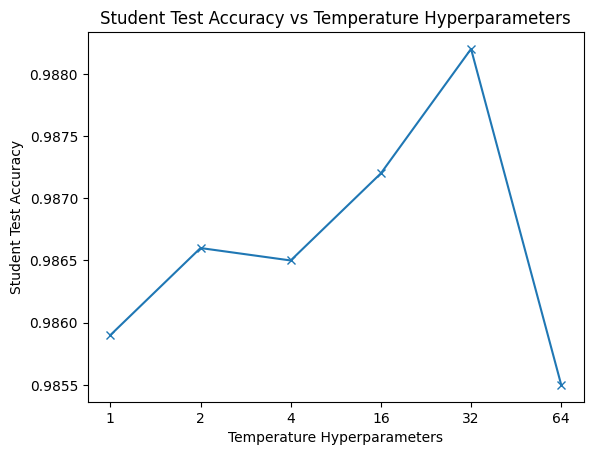

0

In [24]:
import matplotlib.pyplot as plt

temperatureList = [1, 2, 4, 16, 32, 64]
accuracyList = []

# Clear Previous Sessions
tf.keras.backend.clear_session()
for t in temperatureList:
    DISTILLATION_TEMPERATURE = t
    tmp = tf.keras.models.clone_model(fc_model)
    accuracyList.append(train_and_evaluate(tmp, compute_student_loss, teacher=cnn_model, student=tmp)[1][-1].numpy())
    
    # Clear Previous Sessions
    tf.keras.backend.clear_session()
    print(accuracyList)

def draw(temperatureList: list, accuracyList: list):
    plt.figure()
    
    plt.title('Student Test Accuracy vs Temperature Hyperparameters')
    plt.xlabel('Temperature Hyperparameters')
    plt.ylabel('Student Test Accuracy')
    
    plt.plot(accuracyList, marker='x')
    xi = list(range(len(temperatureList)))
    plt.xticks(xi, temperatureList)
    
    plt.show()
    
    return 0

draw(temperatureList, accuracyList)

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential(
  [
      tf.keras.Input(shape=(28, 28, 1)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(784, activation='relu'),
      tf.keras.layers.Dense(784, activation='relu'),
      tf.keras.layers.Dense(10),
  ],
  name="student"
)
fc_model_no_distillation.build()
fc_model_no_distillation.summary()

#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1238730 (4.73 MB)
Trainable params: 1238730 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 001: Loss: 0.244, Accuracy: 96.70%
Epoch 002: Loss: 0.081, Accuracy: 97.46%
Epoch 003: Loss: 0.049, Accuracy: 97.84%
Epoch 004: Loss: 0.034, Accura

([<tf.Tensor: shape=(), dtype=float32, numpy=2.3726003>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1936846>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0515592>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8828207>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.7457466>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.6198155>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.5108223>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.4110593>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.3107247>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.2267243>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1660174>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.1155007>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0617441>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.0217057>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.97955394>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.94686794>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.9188481>,
  <tf.Tensor: shape=(), dtype

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
from keras_flops import get_flops

def statistics(model):
    total_parameters = 0
    for variable in model.trainable_variables:
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim
        total_parameters += variable_parameters
    print(f'Name: {model.name}, Parameter Count: {total_parameters}, FLOP Count: {get_flops(model, batch_size=BATCH_SIZE)}')

statistics(cnn_model)
statistics(fc_model)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Name: teacher, Parameter Count: 1404682, FLOP Count: 7758170624
Name: student, Parameter Count: 1238730, FLOP Count: 633825792


# Implementing the state-of-the-art KD algorithm

In [23]:
# Clear Previous Sessions
tf.keras.backend.clear_session()

# Clone Teacher model
cnn_model = tf.keras.models.clone_model(cnn_model)
cnn_model.build()

# Clone Student model
fc_model = tf.keras.models.clone_model(fc_model)
fc_model.build()

# Build a similar CNN model with less Conv2D layers as teacher assistant
TA_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10),
    ],
    name='TA',
)
TA_model.build()
statistics(cnn_model)
statistics(fc_model)
statistics(TA_model)
# First train the TA model
train_and_evaluate(TA_model, compute_student_loss, teacher=cnn_model, student=TA_model)

# Then use the TA model to train the student
train_and_evaluate(fc_model, compute_student_loss, teacher=TA_model, student=fc_model)

Name: teacher, Parameter Count: 1404682, FLOP Count: 7758170624
Name: student, Parameter Count: 1238730, FLOP Count: 633825792
Name: TA, Parameter Count: 1281034, FLOP Count: 781404672
Epoch 001: Loss: 19.116, Accuracy: 97.16%
Epoch 002: Loss: 19.034, Accuracy: 97.78%
Epoch 003: Loss: 19.015, Accuracy: 98.18%
Epoch 004: Loss: 19.009, Accuracy: 98.17%
Epoch 005: Loss: 19.005, Accuracy: 98.34%
Epoch 006: Loss: 19.000, Accuracy: 98.42%
Epoch 007: Loss: 18.996, Accuracy: 98.46%
Epoch 008: Loss: 18.994, Accuracy: 98.50%
Epoch 009: Loss: 18.993, Accuracy: 98.47%
Epoch 010: Loss: 18.992, Accuracy: 98.49%
Epoch 011: Loss: 18.990, Accuracy: 98.58%
Epoch 012: Loss: 18.987, Accuracy: 98.59%
Epoch 001: Loss: 18.527, Accuracy: 97.44%
Epoch 002: Loss: 18.435, Accuracy: 98.16%
Epoch 003: Loss: 18.418, Accuracy: 98.40%
Epoch 004: Loss: 18.409, Accuracy: 98.47%
Epoch 005: Loss: 18.404, Accuracy: 98.56%
Epoch 006: Loss: 18.401, Accuracy: 98.62%
Epoch 007: Loss: 18.398, Accuracy: 98.62%
Epoch 008: Loss: 

([<tf.Tensor: shape=(), dtype=float32, numpy=19.561369>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.46827>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.367641>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.281805>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.220623>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.16434>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.113659>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.08397>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.059134>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.03324>,
  <tf.Tensor: shape=(), dtype=float32, numpy=19.012642>,
  <tf.Tensor: shape=(), dtype=float32, numpy=18.988836>,
  <tf.Tensor: shape=(), dtype=float32, numpy=18.968796>,
  <tf.Tensor: shape=(), dtype=float32, numpy=18.950743>,
  <tf.Tensor: shape=(), dtype=float32, numpy=18.93726>,
  <tf.Tensor: shape=(), dtype=float32, numpy=18.921904>,
  <tf.Tensor: shape=(), dtype=float32, numpy=18.90916>,
  <tf.Tensor: shape=(), dtype=float32

# XAI method to explain models